# Interpretability: Understanding Predictions Using Car Data

## Overview

This notebook provides an overview of applying Howso Engine to make predictions based on historical data and harnessing Howso Engine’s interpretability capabilities to understand why the predictions were made. Here, we demonstrate these capabilities on vehicle data. We train Howso Engine to predict classes of vehicles, understand potential anomalies, investigate vehicles on a case-by-case basis, and review the data that contributed to the predictions. This is a straightforward example of the power of Howso Engine to gain insights from data. 

## Recipe Goals

This recipe hopes to serve as a use-case driven example of how to use the Howso Engine's interpretability tools to further understand how predictions are derived and what influences them the most.

In [1]:
import os

import pandas as pd
import plotly.io as pio
from sklearn.metrics import (
    accuracy_score,
    f1_score,
)

from howso import engine
from howso.utilities import infer_feature_attributes
from howso.visuals import plot_dataset

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

# Section 1: Model Training and Evaluation

## Step 1: Load Data

Our dataset here is a collection of records describing models of various vehicle models across the last few decades. The data consists of 10 features describing some common properties of each car model.

The last column, vehicle class, is our target variable. We'll use the other variables (with the exception of make and model, as this would be too easy) to build a model. 

In [2]:
df = pd.read_csv('data/vehicle_processed.csv')

# drop any duplicate records
df = df.drop_duplicates()

# keep a copy of the original data for later reference Make & Model
df_original = df.copy()

df = df.drop(['Make', 'Model'], axis=1)
df

,CityMPG,DriveType,FuelType,HighwayMPG,Year,PassengerVolume,LuggageVolume,VehicleClass
0,23,Front-Wheel Drive,Regular,33,1985,77,19,Subcompact Cars
1,17,4-Wheel or All-Wheel Drive,Premium,23,1993,90,14,Compact Cars
2,21,Front-Wheel Drive,Regular,24,1993,88,15,Compact Cars
3,22,Front-Wheel Drive,Regular,29,1993,88,15,Compact Cars
4,23,Front-Wheel Drive,Regular,26,1993,89,13,Compact Cars
...,...,...,...,...,...,...,...,...
23600,21,Front-Wheel Drive,Regular,32,1993,89,12,Compact Cars
23601,19,Front-Wheel Drive,Regular,26,1993,90,14,Compact Cars
23602,20,Front-Wheel Drive,Regular,28,1993,90,14,Compact Cars
23603,18,4-Wheel or All-Wheel Drive,Regular,24,1993,90,14,Compact Cars


> NOTE: The Howso Engine handles missing data quite well natively. This dataset actually contains more than a few missing values in the "DriveType" feature, see below.

In [3]:
df.isnull().sum()

CityMPG              0
DriveType          783
FuelType             0
HighwayMPG           0
Year                 0
PassengerVolume      0
LuggageVolume        0
VehicleClass         0
dtype: int64

In [4]:
df[df.DriveType.isnull()]

,CityMPG,DriveType,FuelType,HighwayMPG,Year,PassengerVolume,LuggageVolume,VehicleClass
9707,15,NaN,Regular,20,1984,50,22,Two Seaters
9708,16,NaN,Regular,20,1984,50,22,Two Seaters
9709,16,NaN,Regular,22,1984,50,22,Two Seaters
9710,18,NaN,Regular,24,1984,50,22,Two Seaters
9711,17,NaN,Regular,24,1984,74,7,Minicompact Cars
...,...,...,...,...,...,...,...,...
10848,14,NaN,Regular,19,1984,110,50,Midsize-Large Station Wagons
10849,13,NaN,Regular,19,1984,112,53,Midsize-Large Station Wagons
10850,13,NaN,Regular,19,1984,112,53,Midsize-Large Station Wagons
10851,13,NaN,Regular,20,1984,110,50,Midsize-Large Station Wagons


Below we also display the different values seen in the data for our desired target feature, "VehicleClass".

In [5]:
labels = df['VehicleClass'].unique()
list(labels)

['Subcompact Cars',
 'Compact Cars',
 'Midsize Cars',
 'Large Cars',
 'Small Station Wagons',
 'Midsize-Large Station Wagons',
 'Minicompact Cars',
 'Two Seaters',
 'Midsize Station Wagons',
 'Special Purpose Vehicle 4WD',
 'Sport Utility Vehicle - 4WD',
 'Sport Utility Vehicle - 2WD',
 'Small Pickup Trucks 4WD',
 'Small Sport Utility Vehicle 4WD',
 'Small Sport Utility Vehicle 2WD',
 'Special Purpose Vehicle 2WD',
 'Standard Sport Utility Vehicle 2WD',
 'Standard Sport Utility Vehicle 4WD']

## Step 2: Train and Analyze

For the purpose of this demo we will use the data of cars made before 2021 to make predictions on data representing cars made in 2021.

In [6]:
test_index = df[df['Year'].isin([2021])].index
train_index = df[~df['Year'].isin([2021])].index

print("train size (ratio): " + str(round(len(train_index) / df.shape[0], 2) ))
print("test size (ratio): " + str(round(len(test_index) / df.shape[0], 2) ) )

train size (ratio): 0.97
test size (ratio): 0.03


In [7]:
df_train = df.loc[train_index, :]
X_test = df.loc[test_index, :].drop('VehicleClass', axis=1)
y_test = df.loc[test_index, 'VehicleClass']

As mentioned in other recipes, we strongly encourage users to always inspect the feature attributes returned by `infer_feature_attributes`. This function uses some heuristics to attempt to infer feature types and other attributes, but an incorrect assumption can drastically impact the performance of the Trainee and give undesired results.

Additionally, users should not be afraid to manually alter the feature attributes, especially for attributes such as "type" or "bounds".

In [8]:
# Explicitly specify continuous features
custom_features = {}

cont_features = ['CityMPG', 'HighwayMPG', 'PassengerVolume', 'LuggageVolume', 'Year']
for ft in cont_features:
    custom_features[ft] = {'type': 'continuous'}

# Infer feature attributes, with a dictionary where types for continuous feature
# are pre-defined
features = infer_feature_attributes(df, features=custom_features)

features

{'CityMPG': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'integer', 'size': 8},
  'bounds': {'allow_null': False}},
 'HighwayMPG': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'integer', 'size': 8},
  'bounds': {'allow_null': False}},
 'PassengerVolume': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'integer', 'size': 8},
  'bounds': {'allow_null': False}},
 'LuggageVolume': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'integer', 'size': 8},
  'bounds': {'allow_null': False}},
 'Year': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'integer', 'size': 8},
  'bounds': {'allow_null': False}},
 'DriveType': {'type': 'nominal',
  'original_type': {'data_type': 'string'},
  'bounds': {'allow_null': True}}

In [9]:
# Specify context and action features
context_features = features.get_names(without=['VehicleClass'])
action_features = ['VehicleClass']

# Initialize the Trainee, train it, and analyze the data
t = engine.Trainee(name='Engine - Car Type Recipe',
                    features=features,
                    overwrite_existing=True)

t.train(df_train)

t.analyze()

## Step 3: Predict on the Test Set

Now let's see how well the Trainee can predict "VehicleClass" of the test data. Let's inspect both accuracy and F1 score for each class.

In [10]:
results = t.react(X_test, action_features=action_features, context_features=context_features)
predictions = results['action']['VehicleClass']

In [11]:
accuracy = round(accuracy_score(y_test, predictions), 3)
print("Accuracy: " +  str(accuracy))
print("=" * 30)


print("Per-Class F1 Scores:\n")
score = f1_score(y_test, predictions, average=None)
for i in range(0, len(set(y_test))):
    print(labels[i] + ': ' + str(round(score[i], 3)))

Accuracy: 0.926
Per-Class F1 Scores:

Subcompact Cars: 0.938
Compact Cars: 0.898
Midsize Cars: 0.918
Large Cars: 0.909
Small Station Wagons: 0.986
Midsize-Large Station Wagons: 0.857
Minicompact Cars: 0.8
Two Seaters: 0.846
Midsize Station Wagons: 1.0
Special Purpose Vehicle 4WD: 0.667
Sport Utility Vehicle - 4WD: 0.974


We see we have satisfactory F1 scores for most of the classes, but there are one or two that fall a bit behind. Let's check if those classes are well represented in the training data. 

In [12]:
df_train['VehicleClass'].value_counts()

VehicleClass
Compact Cars                          5511
Subcompact Cars                       4743
Midsize Cars                          4678
Large Cars                            2152
Small Station Wagons                  1474
Minicompact Cars                      1294
Midsize-Large Station Wagons           590
Midsize Station Wagons                 475
Two Seaters                            157
Sport Utility Vehicle - 4WD            135
Small Sport Utility Vehicle 2WD         90
Small Sport Utility Vehicle 4WD         50
Sport Utility Vehicle - 2WD             50
Standard Sport Utility Vehicle 4WD      15
Special Purpose Vehicle 2WD              6
Standard Sport Utility Vehicle 2WD       5
Special Purpose Vehicle 4WD              3
Small Pickup Trucks 4WD                  1
Name: count, dtype: int64

Unsurprisingly, it looks like the class with the lowest F1 score among the test set predictions is one of the classes with the least training data. This should ease our concerns for now. Let's move on.

# Section 2: Leveraging Interpretability

## Step 1: Identifying Anomalous Cases

One way to investigate your data is to identify the most anomalous cases in the dataset. The Howso Engine allows users to do this easily in many ways. Here we demonstrate how to calculate the "Familiarity Conviction (Addition)" for every case in the model then display those cases that have both the highest and lowest values.

> Reminder: All forms of Conviction in the Howso Engine are a ratio of expected surprisal to observed surprisal with a range of (0, inf). Knowing this, a conviction value of 1.0 indicates that the case presents the expected level of surprisal. Furthemore, this means that both low values (< 1.0) and high values (> 1.0) indicate a deviation from the expected level of surprisal. It isn't straightforward to define a threshold of conviction that indicates a "true" anomaly, we recommend tuning thresholds like this on a per-dataset basis. However, it usually a safe bet to regard cases with the lowest and highest conviction values to be the most anomalous.

In [13]:
# react_into_features computes the specified values and caches them into every case of the model as a feature
t.react_into_features(familiarity_conviction_addition=True)
stored_convictions = t.get_cases(session=t.active_session, features=['familiarity_conviction_addition','.session_training_index', '.session'])

In [14]:
convict_df = df_original.loc[train_index].reset_index(drop=True).join(stored_convictions).rename(columns={'familiarity_conviction_addition':'convictions'})
print("The cases with the lowest Familiarity Convictions:")
convict_df.sort_values('convictions').head()

The cases with the lowest Familiarity Convictions:


,CityMPG,DriveType,FuelType,HighwayMPG,Make,Model,Year,PassengerVolume,LuggageVolume,VehicleClass,convictions,.session_training_index,.session
12462,77,Front-Wheel Drive,Electricity,68,CODA Automotive,CODA,2013,72,14,Subcompact Cars,0.005568,12462,7162b4c4-a056-4a60-92c0-438a7e7eb5ca
11727,77,Front-Wheel Drive,Electricity,68,CODA Automotive,CODA,2012,72,14,Subcompact Cars,0.005761,11727,7162b4c4-a056-4a60-92c0-438a7e7eb5ca
11654,106,Front-Wheel Drive,Electricity,92,Nissan,Leaf,2012,90,23,Midsize Cars,0.012844,11654,7162b4c4-a056-4a60-92c0-438a7e7eb5ca
10906,106,Front-Wheel Drive,Electricity,92,Nissan,Leaf,2011,90,23,Midsize Cars,0.013364,10906,7162b4c4-a056-4a60-92c0-438a7e7eb5ca
6513,13,Rear-Wheel Drive,Regular,18,Spyker,C8 Laviolette,2005,47,4,Minicompact Cars,0.015929,6513,7162b4c4-a056-4a60-92c0-438a7e7eb5ca


In [15]:
print("The cases with the highest Familiarity Convictions:")
convict_df.sort_values('convictions', ascending=False).head()

The cases with the highest Familiarity Convictions:


,CityMPG,DriveType,FuelType,HighwayMPG,Make,Model,Year,PassengerVolume,LuggageVolume,VehicleClass,convictions,.session_training_index,.session
10714,20,Rear-Wheel Drive,Premium,27,Lexus,IS 350/IS 350C,2011,88,11,Subcompact Cars,17004.064143,10714,7162b4c4-a056-4a60-92c0-438a7e7eb5ca
12367,11,Rear-Wheel Drive,Premium,18,Bentley,Mulsanne,2013,100,11,Midsize Cars,7082.733426,12367,7162b4c4-a056-4a60-92c0-438a7e7eb5ca
4349,18,Front-Wheel Drive,Regular,26,Mitsubishi,Galant,2002,96,14,Midsize Cars,3626.461115,4349,7162b4c4-a056-4a60-92c0-438a7e7eb5ca
5172,18,Rear-Wheel Drive,Premium,26,BMW,325ci Convertible,2004,74,9,Minicompact Cars,2350.969246,5172,7162b4c4-a056-4a60-92c0-438a7e7eb5ca
14018,25,Front-Wheel Drive,Regular,34,Volkswagen,Jetta,2015,94,16,Compact Cars,1979.574108,14018,7162b4c4-a056-4a60-92c0-438a7e7eb5ca


## Step 2. Investigate a Single Prediction

To gain insight into the Trainee's predictions, we will take a single case representing the Kia K900 and make a prediction on it. In our call to `react`, we will also specify some additional requested information with the `details` parameter that will provide us with some interpretability tools to help understand how the Trainee came to it's prediction.

First we display ths case below, so we know about the case we are discussing. Notably, we see its "VehicleClass" is "Large Cars" which is our action feature.

In [16]:
# Investigate the Kia K900 as an example
k900 = convict_df[(convict_df.Model=='K900') & (convict_df.Year==2015)].iloc[0, :]
k900_case_indices = [(k900['.session'], k900['.session_training_index'])]
k900

CityMPG                                                      18
DriveType                                      Rear-Wheel Drive
FuelType                                                Regular
HighwayMPG                                                   26
Make                                                        Kia
Model                                                      K900
Year                                                       2015
PassengerVolume                                             110
LuggageVolume                                                16
VehicleClass                                         Large Cars
convictions                                            1.061735
.session_training_index                                   13336
.session                   7162b4c4-a056-4a60-92c0-438a7e7eb5ca
Name: 13336, dtype: object

<img src="data/K900_overview.png" width="320">

Howso Engine's power is in its interpretability. Let's see what the model can tell us about this car.

In [17]:
# Specify all the desired details, which will augment the return value of react
# to include additional information
details = {'most_similar_cases': True,
           'num_most_similar_cases': 30,
           'boundary_cases': True,
           'num_boundary_cases': 30,
           'influential_cases': True,
           'robust_residuals': True,
           'robust_influences': True,
           'feature_mda': True,
           'feature_residuals': True}

new_result = t.react(case_indices=k900_case_indices,
                     action_features=action_features,
                     preserve_feature_values=context_features,
                     leave_case_out=True, details=details)

Let's also see where our Kia K900 stands among the other data. To do this, we show a scatterplot with axes of "LuggageVolume" and "PassengerVolume". Here the colors indicate the "VehicleClass". With these colors, we can see that the Kia K900 lies between many other "Large Cars" in terms of these two features, we can reasonably estimate that this case will get the correct predicted value.

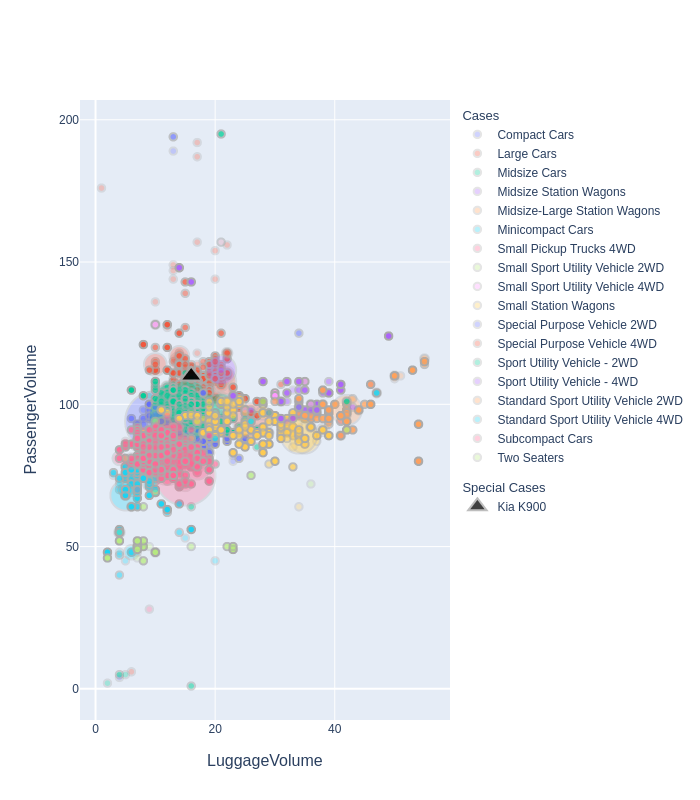

In [18]:
plot_dataset(
    convict_df, "LuggageVolume", "PassengerVolume",
    highlight_selection_conditions={"Make": "Kia", "Model": "K900", "Year": 2015},
    highlight_label="Kia K900",
    alpha=0.3,
    hue="VehicleClass",
    size="convictions",
)

To check if we got the correct predicted value for "VehicleClass" we can check the "action" key of the dictionary returned from `react`.

In [19]:
new_result['action']['VehicleClass'][0]

'Large Cars'

So we see we got the correct prediction from the Trainee. But what played into that decision?

Below we show all of the different "details" that were returned in the `react` response. These details are what will provide us with in-depth interpretability information to further understand how the prediction was made.

In [20]:
list(new_result['details'].keys())

['influential_cases',
 'boundary_cases',
 'most_similar_cases',
 'action_features',
 'feature_residuals',
 'feature_mda']

There is a LOT of information here, a few interesting bits:

1. Most similar cases: These cases most similar to the K900 we predicted according to the Howso Engine.
2. Boundary cases: These are the cases most similar to the case we predicted in terms of context features, but with differing values for the action feature(s).

## Step 3: Inspect the Similar cases and Boundary cases

First let's look at the most similar cases. In this list of similar cases, we see some other versions of the K900 and the Hyundai Genesis.

Conveniently, if we do some research, we can find that the K900 is "a derivative of the Hyundai Equus and Genesis". So we see that the origin of the K900 falls right inline with what we see in the data.

In [21]:
most_similar_df = pd.DataFrame(new_result['details']['influential_cases'][0]).drop('VehicleClass', axis=1)

most_similar_records = pd.merge(most_similar_df, df_original, on=context_features, how='left')

cols_order = ['.influence_weight', '.session', '.session_training_index', 'Make', 'Model', 'Year'] + most_similar_records.columns.drop(['.session_training_index', '.session', '.influence_weight', 'Make', 'Model', 'Year']).tolist()

most_similar_records = most_similar_records.loc[ : , cols_order]
most_similar_records.head(10)

,.influence_weight,.session,.session_training_index,Make,Model,Year,PassengerVolume,DriveType,CityMPG,LuggageVolume,FuelType,HighwayMPG,VehicleClass
0,0.282691,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,13273,Hyundai,Genesis,2014,109,Rear-Wheel Drive,18,16,Regular,27,Large Cars
1,0.211600,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,14482,Kia,K900,2016,110,Rear-Wheel Drive,17,16,Regular,25,Large Cars
2,0.175172,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,15110,Kia,K900,2017,110,Rear-Wheel Drive,17,16,Regular,25,Large Cars
3,0.173502,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,10632,Hyundai,Genesis,2011,109,Rear-Wheel Drive,18,16,Regular,27,Large Cars
4,0.157034,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,9915,Hyundai,Genesis,2010,109,Rear-Wheel Drive,18,16,Regular,27,Large Cars


<img src="data/Firstgen_K9.png" width="1080">

Now let's look at the boundary cases.

Here we see a many cases that have very comparable "LuggageVolume", "HighwayMPG", and "PassengerVolume". Additionally, these cases also have the same "DriveType" and "VehicleClass". However, all of these classes are not "Large Cars" like the K900 we are discussing was predicted to be. This is the idea of boundary cases, they serve to help demonstrate to users what the most similar cases with a different action feature value look like. 

This can be used to help users see what context feature values may indicate a decision boundary.

In [22]:
boundary_case_df = pd.DataFrame(new_result['details']['boundary_cases'][0]).drop('VehicleClass', axis=1)

boundary_records = pd.merge(boundary_case_df, df_original, on=context_features, how='inner')

cols_order = ['.influence_weight', '.session', '.session_training_index', 'Make', 'Model', 'Year'] + boundary_records.columns.drop(['.session_training_index',  '.session', '.influence_weight', 'Make', 'Model', 'Year']).tolist()

boundary_records = boundary_records.loc[ : , cols_order]
boundary_records.head(10)

,.influence_weight,.session,.session_training_index,Make,Model,Year,PassengerVolume,DriveType,CityMPG,LuggageVolume,FuelType,HighwayMPG,VehicleClass
0,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,8138,Cadillac,CTS,2008,96,Rear-Wheel Drive,18,14,Regular,26,Midsize Cars
1,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,8484,Cadillac,CTS,2009,97,Rear-Wheel Drive,18,14,Regular,26,Midsize Cars
2,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,8489,Cadillac,STS,2009,102,Rear-Wheel Drive,17,14,Regular,26,Midsize Cars
3,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,8895,Cadillac,CTS,2010,100,Rear-Wheel Drive,18,16,Regular,27,Midsize Cars
4,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,8897,Cadillac,STS,2010,102,Rear-Wheel Drive,18,14,Regular,27,Midsize Cars
5,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,10293,Cadillac,CTS,2010,100,Rear-Wheel Drive,16,16,Regular,26,Midsize Cars
6,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,10596,Cadillac,CTS,2011,99,Rear-Wheel Drive,18,15,Regular,27,Midsize Cars
7,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,10597,Cadillac,STS,2011,102,Rear-Wheel Drive,18,14,Regular,27,Midsize Cars
8,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,10608,Cadillac,CTS,2011,99,Rear-Wheel Drive,16,15,Regular,26,Midsize Cars
9,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,10921,Dodge,Challenger,2011,91,Rear-Wheel Drive,18,16,Regular,27,Compact Cars


Notice how similar the boundary case are to the chosen example (Kia K900), with the exception of the 'VehicleClass'. Also, the ".influence_weight" is zero for all boundary cases which indicates the case of interest does not lie on the boundary.

Let's plot and identify the similar cases and boundary cases. Keep in mind we are only visualizing 2 of the 6 predictor variables. Therefore similar and boundary cases may not be right next to, or exactly on a class boundary, in the following plots.

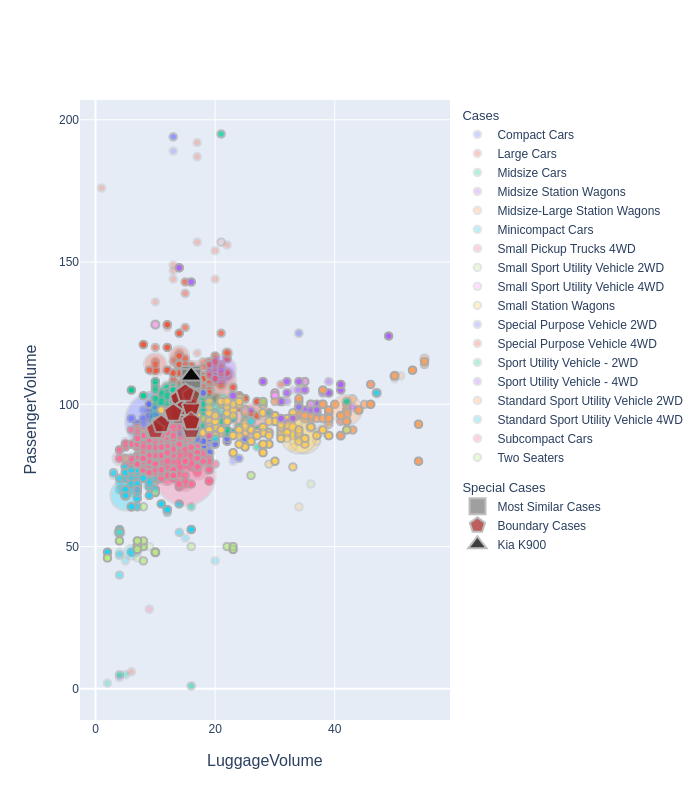

In [23]:
plot_dataset(
    convict_df, "LuggageVolume", "PassengerVolume",
    highlight_selection_conditions={"Make": "Kia", "Model": "K900", "Year": 2015},
    highlight_label="Kia K900",
    alpha=0.3,
    hue="VehicleClass",
    size="convictions",
    most_similar_cases=most_similar_df,
    boundary_cases=boundary_case_df,
)

It's a bit difficult to see the similar cases in this plot as they are all very close to the K900 we are predicting. However we *can* see that the boundary cases are close, but not as close as the similar cases. Additionally, we see that the boundary cases are within a cluster of a different color, indicating their belonging to another class.

## Step 4. Inspect Feature Importance Metrics

First we can inspect the Mean Decrease in Accuracy for the local model around the prediction:

In [24]:
new_result['details']['feature_mda'][0]

{'PassengerVolume': 0.24549999999999983,
 'DriveType': 0.10399999999999993,
 'CityMPG': 0.007999999999999952,
 'LuggageVolume': 0.05600000000000027,
 'FuelType': -0.08799999999999986,
 'HighwayMPG': -0.04599999999999985,
 'Year': -0.06199999999999997}

As observed from the 'most similar' and 'boundary' cases above, we can see that there were many vehicles which were similar to each other in that space. With the 'LuggageVolume' being a critical feature in distinguishing the VehicleClass in that region.
Higher values of MDA indicate that the feature is important for predicting the action feature.

> Note: MDA (Mean Decrease in Accuracy) measures are effectively an approximations of the SHAP value.

Another informative comparison is to check the local residuals against the global residuals to understand the uncertainty and predictability of the features in the area around the prediction in reference to those qualities of the model as a whole. 

In [25]:
feature_residuals_dicts = new_result['details']['feature_residuals']
feature_residuals = pd.DataFrame(list(feature_residuals_dicts[0].items()))
feature_residuals = feature_residuals.T
feature_residuals.columns = feature_residuals.loc[0]
feature_residuals = feature_residuals.drop(0, axis=0)
print("Local Model Residuals")
feature_residuals

Local Model Residuals


,VehicleClass,PassengerVolume,DriveType,CityMPG,LuggageVolume,FuelType,HighwayMPG,Year
1,0.380885,7.029279,0.609722,1.445171,1.811911,0.467119,1.983813,6.920893


In [26]:
t.react_into_trainee(residuals=True)
print("Global Model Residuals")
t.get_prediction_stats(stats=['mae'], robust=False)

Global Model Residuals


,VehicleClass,PassengerVolume,DriveType,CityMPG,LuggageVolume,FuelType,HighwayMPG,Year
mae,0.047299,1.095062,0.113374,0.555066,0.766709,0.112586,0.786066,1.973637


The ‘Year’ feature jumps out in the above comparison – in the global residual the MAE was approximately 2, but in the localized region the MAE is much higher.

This is perhaps not a big surprise considering the cases we chose to investigate (Kia K900) which was a luxury car, which generally will have less variation year over year hence the ‘Year’ feature is more difficult to predict accurately.


## Step 5: Further Inspection of Anomalous Cases

We identified some anomalous cases earlier and displayed them, but we didn't do much in the way of qualifying their anomalous nature. One good way to do this, is to view the most similar and boundary cases of the anomalous cases. 

Below we define a helper method that will help us extract and display this information conveniently for a given case (it's session id and training index, which are used as a pair to specify cases in the Howso Engine).

In [27]:
# Helper function to extract out most similar and boundary cases
def get_info(case):
    details = {'most_similar_cases': True,
               'num_most_similar_cases': 10,
               'boundary_cases': True,
               'num_boundary_cases': 10,
               'influential_cases': True}

    new_result = t.react(case_indices=case, preserve_feature_values=context_features, leave_case_out=True,
                         details=details, action_features=action_features)

    print('')
    most_similar_df = pd.DataFrame(new_result['details']['influential_cases'][0]).drop('VehicleClass', axis=1)

    most_similar_records = pd.merge(most_similar_df, df_original, on=context_features, how='left')

    cols_order = ['.influence_weight', '.session', '.session_training_index', 'Make', 'Model', 'Year'] + most_similar_records.columns.drop(['.session_training_index', '.session', '.influence_weight', 'Make', 'Model', 'Year']).tolist()

    most_similar_records = most_similar_records.loc[ : , cols_order]

    print('Similar cases:')
    display(most_similar_records)

    boundary_case_df = pd.DataFrame(new_result['details']['boundary_cases'][0]).drop('VehicleClass', axis=1)

    boundary_records = pd.merge(boundary_case_df, df_original, on=context_features, how='inner')

    cols_order = ['.influence_weight', '.session', '.session_training_index', 'Make', 'Model', 'Year'] + boundary_records.columns.drop(['.session_training_index',  '.session', '.influence_weight', 'Make', 'Model', 'Year']).tolist()

    boundary_records = boundary_records.loc[ : , cols_order]
    print('Boundary cases:')
    display(boundary_records)

In [28]:
# Pick the lowest and highest conviction cases
low_convict_record = convict_df.sort_values('convictions', ascending=True).iloc[0, :]
low_convict_case_index = [(low_convict_record['.session'], low_convict_record['.session_training_index'])]

high_convict_record = convict_df.sort_values('convictions', ascending=False).iloc[0, :]
high_convict_case_index = [(high_convict_record['.session'], high_convict_record['.session_training_index'])]

In [29]:
# Lowest conviction record
low_convict_record

CityMPG                                                      77
DriveType                                     Front-Wheel Drive
FuelType                                            Electricity
HighwayMPG                                                   68
Make                                            CODA Automotive
Model                                                      CODA
Year                                                       2013
PassengerVolume                                              72
LuggageVolume                                                14
VehicleClass                                    Subcompact Cars
convictions                                            0.005568
.session_training_index                                   12462
.session                   7162b4c4-a056-4a60-92c0-438a7e7eb5ca
Name: 12462, dtype: object

In [30]:
# View its similar and boundary cases
get_info(low_convict_case_index)


Similar cases:


,.influence_weight,.session,.session_training_index,Make,Model,Year,PassengerVolume,DriveType,CityMPG,LuggageVolume,FuelType,HighwayMPG,VehicleClass
0,0.980582,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,11727,CODA Automotive,CODA,2012,72,Front-Wheel Drive,77,14,Electricity,68,Subcompact Cars
1,0.005147,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,15244,BYD,e6,2016,88,Front-Wheel Drive,73,16,Electricity,71,Small Sport Utility Vehicle 2WD
2,0.004953,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,15741,BYD,e6,2017,88,Front-Wheel Drive,73,16,Electricity,71,Small Sport Utility Vehicle 2WD


Boundary cases:


,.influence_weight,.session,.session_training_index,Make,Model,Year,PassengerVolume,DriveType,CityMPG,LuggageVolume,FuelType,HighwayMPG,VehicleClass
0,0.000000,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,13770,Mercedes-Benz,B-Class Electric Drive,2014,90,Front-Wheel Drive,85,22,Electricity,83,Midsize Cars
1,0.000000,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,14207,Mercedes-Benz,B-Class Electric Drive,2015,90,Front-Wheel Drive,85,22,Electricity,82,Midsize Cars
2,0.000000,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,14827,Mercedes-Benz,B250e,2016,90,Front-Wheel Drive,85,22,Electricity,82,Midsize Cars
3,0.005147,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,15244,BYD,e6,2016,88,Front-Wheel Drive,73,16,Electricity,71,Small Sport Utility Vehicle 2WD
4,0.000000,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,15369,Mercedes-Benz,B250e,2017,90,Front-Wheel Drive,85,22,Electricity,82,Midsize Cars
5,0.004953,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,15741,BYD,e6,2017,88,Front-Wheel Drive,73,16,Electricity,71,Small Sport Utility Vehicle 2WD
6,0.004791,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,16470,BYD,e6,2018,88,Front-Wheel Drive,73,16,Electricity,71,Small Sport Utility Vehicle 2WD
7,0.004528,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,17714,BYD,e6,2020,88,Front-Wheel Drive,73,16,Electricity,71,Small Sport Utility Vehicle 2WD
8,0.000000,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,17916,Porsche,Taycan Turbo,2020,108,All-Wheel Drive,68,16,Electricity,71,Large Cars
9,0.000000,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,17916,Porsche,Taycan 4S Perf Battery Plus,2020,108,All-Wheel Drive,68,16,Electricity,71,Large Cars


We see that our lowest conviction record is an electric car. This is fairly unsurprising, at this is definitely not a common type of car, especially for the period of time that this dataset represents. We additionally see that almost all of the ".influence_weight" is in a single one of its similar cases. This makes up for a large part of it's low Familiarity Conviction.

Additionally, looking at the Boundary Cases, we see many other cars that are also electric, but most have more luggage volume or better highway milage. Not to mention that they are also distinctly different from the anomalous case as they are not a Subcompact car.

In [31]:
# Highest conviction record
high_convict_record

CityMPG                                                      20
DriveType                                      Rear-Wheel Drive
FuelType                                                Premium
HighwayMPG                                                   27
Make                                                      Lexus
Model                                            IS 350/IS 350C
Year                                                       2011
PassengerVolume                                              88
LuggageVolume                                                11
VehicleClass                                    Subcompact Cars
convictions                                        17004.064143
.session_training_index                                   10714
.session                   7162b4c4-a056-4a60-92c0-438a7e7eb5ca
Name: 10714, dtype: object

In [32]:
# View its similar and boundary cases
get_info(high_convict_case_index)


Similar cases:


,.influence_weight,.session,.session_training_index,Make,Model,Year,PassengerVolume,DriveType,CityMPG,LuggageVolume,FuelType,HighwayMPG,VehicleClass
0,0.408094,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,10712,Lexus,IS 250/IS 250C,2011,88,Rear-Wheel Drive,19,11,Premium,27,Subcompact Cars
1,0.157941,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,11331,Lexus,IS 350/IS 350C,2012,88,Rear-Wheel Drive,19,11,Premium,27,Subcompact Cars
2,0.157941,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,11331,Lexus,IS 250/IS 250C,2012,88,Rear-Wheel Drive,19,11,Premium,27,Subcompact Cars
3,0.157941,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,11331,BMW,335i Coupe,2012,88,Rear-Wheel Drive,19,11,Premium,27,Subcompact Cars
4,0.157941,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,11328,Lexus,IS 350/IS 350C,2012,88,Rear-Wheel Drive,19,11,Premium,27,Subcompact Cars
5,0.157941,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,11328,Lexus,IS 250/IS 250C,2012,88,Rear-Wheel Drive,19,11,Premium,27,Subcompact Cars
6,0.157941,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,11328,BMW,335i Coupe,2012,88,Rear-Wheel Drive,19,11,Premium,27,Subcompact Cars
7,0.157941,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,11557,Lexus,IS 350/IS 350C,2012,88,Rear-Wheel Drive,19,11,Premium,27,Subcompact Cars
8,0.157941,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,11557,Lexus,IS 250/IS 250C,2012,88,Rear-Wheel Drive,19,11,Premium,27,Subcompact Cars
9,0.157941,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,11557,BMW,335i Coupe,2012,88,Rear-Wheel Drive,19,11,Premium,27,Subcompact Cars


Boundary cases:


,.influence_weight,.session,.session_training_index,Make,Model,Year,PassengerVolume,DriveType,CityMPG,LuggageVolume,FuelType,HighwayMPG,VehicleClass
0,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,4764,Mercedes-Benz,C230 Kompressor,2003,88,Rear-Wheel Drive,20,12,Premium,28,Compact Cars
1,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,5398,Mercedes-Benz,C230 Kompressor,2004,89,Rear-Wheel Drive,20,12,Premium,27,Compact Cars
2,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,10537,Mercedes-Benz,C300,2011,88,Rear-Wheel Drive,18,12,Premium,25,Compact Cars
3,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,11376,Mercedes-Benz,C350,2012,88,Rear-Wheel Drive,20,12,Premium,29,Compact Cars
4,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,11584,BMW,640i Convertible,2012,89,Rear-Wheel Drive,20,12,Premium,30,Compact Cars
5,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,12059,Mercedes-Benz,C350,2013,88,Rear-Wheel Drive,20,12,Premium,28,Compact Cars
6,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,12153,Mercedes-Benz,C350,2013,88,Rear-Wheel Drive,20,12,Premium,29,Compact Cars
7,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,12659,Mercedes-Benz,C350,2014,88,Rear-Wheel Drive,20,12,Premium,29,Compact Cars
8,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,13905,BMW,435i Coupe,2015,90,Rear-Wheel Drive,20,11,Premium,29,Compact Cars
9,0,7162b4c4-a056-4a60-92c0-438a7e7eb5ca,16392,Lexus,IS 350,2018,90,Rear-Wheel Drive,20,11,Premium,28,Compact Cars


Looking at the highest conviction case, we should expect a case that is barely surprising. It has a conviction value of over 10,000, which is to say that the case is over 10,000 times less surprising than we expect from the average new case. Looking at the similar cases, it becomes obvious why this happened. Every similar case is exact same model of car with practically the *exact* same feature values except for "PassengerVolume" which is merely 1% different.

Then looking at boundary cases, we see many Rolls-Royce models that also have almost identical feature values across the board, save for "PassengerVolume" again, which is now about 5-7% different, but apparently this gives cause to classify these cars as "Compact Cars".

# Conclusion

This use-case driven demo demonstrating the interpretability and predictive power of the Howso Engine hope to serve as a strong example for Howso Engine users who have created a Trainee and want ideas or guidance on how to make predictions that they can deeply understand and investigate.